In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint as sci_odeint
from torchdiffeq import odeint as torch_odeint

# Solving ODE with scipy solver

Here we are creating a minimal example of using scikit ODE solver

In [36]:
def ode(y, t, A, B, C):
    """Defining an ODE here"""
    dydt = (-A * y + B * t + C)
    return dydt

# time steps where we want to see the solution function
t = range(-50, 50, 1)

# ODE constants
A = .2
B = 10
C = 4

# solution
y = sci_odeint(
    func=ode,
    y0=1000,
    t=t,
    args=(A, B, C)
)

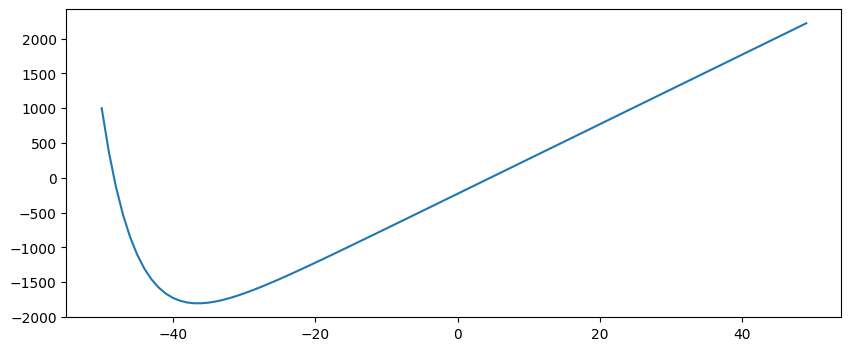

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(t, y)

# Solving ODE with torchdiffeq solver

Switching to ODE solver that takes in torch tensors of arbitrary dimensionality.

## 1d vector input to the solver

In [13]:
def ODE_1d(t, y):
    """ODE, solution to which is a 2d spiral"""
    A = .05
    B = .5
    return (-A * y**2  + B)

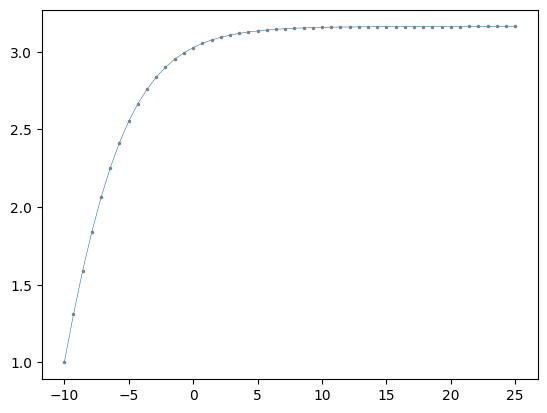

In [16]:
y0 = torch.tensor([1.])
time_range = torch.linspace(-10., 25., 50)
solution = torch_odeint(func=ODE_1d, y0=y0, t=time_range, 
                        atol=1e-5, rtol=1e-5)
plt.plot(time_range, solution,
         marker='.', markerfacecolor='gray', markeredgecolor='gray', markersize=3,
         linewidth=.4)

## 2d vector input to the solver

In [21]:
def ODE_2d(t, y):
    """ODE function"""
    coef = torch.tensor([[-5., .1], [.1, -5.]])
    return (y ** 2) @ coef

y0 = torch.tensor([[2., 1.]])
time_range = torch.linspace(-25., 25., 100)
solution = torch_odeint(func=ODE_2d, y0=y0, t=time_range, 
                        atol=1e-4, rtol=1e-4)

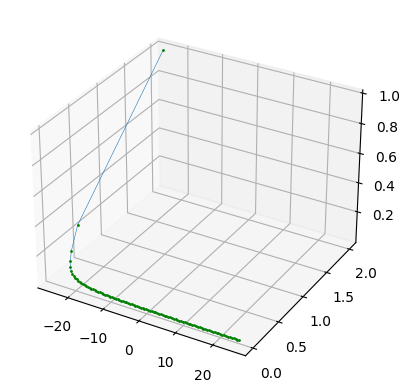

In [27]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(xs=time_range,
        ys=solution.detach().numpy()[:, 0][:, 0],
        zs=solution.detach().numpy()[:, 0][:, 1],
        marker='.', markerfacecolor='green', markeredgecolor='green', markersize=2, linewidth=.4)

## 2d spiral input to the solver

In [40]:
def ODE_2d(t, y):
    """ODE solution to which is a 3d spiral"""
    coef = torch.tensor([[-0.1, 2.0],   # matrix of coefficients that determine the spiral shape
                        [-2.0, -0.1]])
    ode = y**3 @ coef
    return ode

In [41]:
y0 = torch.tensor([[2., 0.]])     # starting point from which spiral is drawn
t = torch.linspace(0., 50., 500)  # all time steps for which spiral is calculated

solution = torch_odeint(ODE_2d, y0=y0, t=t)

Text(0.5, 0.5, 'Y')

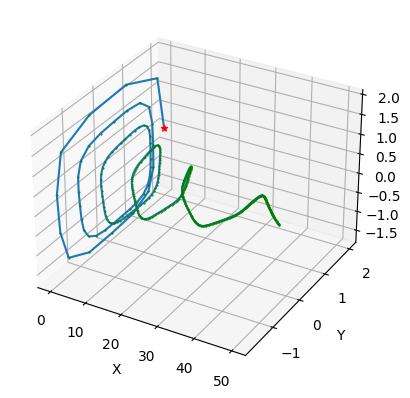

In [54]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(xs=[0], ys=[2], zs=[0], marker='*', color='red') # plotting starting point y0
ax.plot(xs=t,
        ys=solution.detach().numpy()[:, 0][:, 0],
        zs=solution.detach().numpy()[:, 0][:, 1],
        marker='.', markerfacecolor='green', markeredgecolor='green', markersize=1,)
ax.set_xlabel('X'); ax.set_ylabel('Y')

Dimension of timesteps is only plotted to demonstrate the order in which solver reconstructed the original function. We see that the start is indeed from the y0 point provided (see red marker on the plot). We can redraw the last 2 dimensions only to see the spiral itself, i.e. the original function, solution of the parametrised ODE.

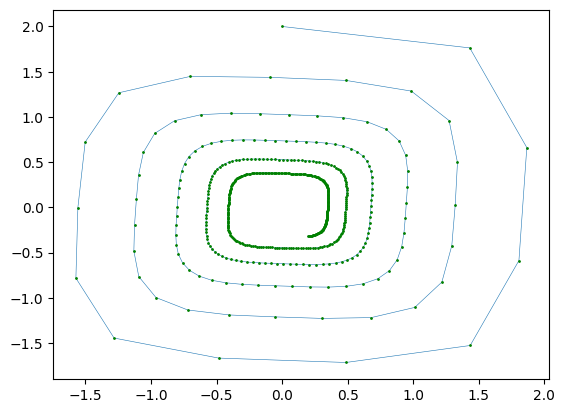

In [35]:
plt.plot(solution[:, 0][:, 1].detach().numpy(),
         solution[:, 0][:, 0].detach().numpy(), 
         marker='.', markerfacecolor='green', markeredgecolor='green', markersize=2,
         linewidth=.4)

# Using torchdiffeq solver in forward pass

This is an attempt to reproduce this example from the 2018 paper authors:
github.com/rtqichen/torchdiffeq/blob/master/examples/ode_demo.py